### Binary Classification Model for Kaggle Tabular Playground Series Apr 2021 Using Python and AutoKeras
### David Lowe
### June 15, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Apr 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the cross-validated TensorFlow models achieved an average accuracy benchmark of 0.7702 after running for 45 trials. When we applied the final model to Kaggle's test dataset, the model achieved an accuracy score of 0.7865.

CONCLUSION: In this iteration, the AutoKeras-generated TensorFlow model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 Apr Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-apr-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-apr-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

  Cloning https://github.com/keras-team/keras-tuner.git to /tmp/pip-req-build-onpf_oxj
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-onpf_oxj
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-cp37-none-any.whl size=93822 sha256=d1312963148c8ac442f439aff9f10ddaf0cf8ff9e5daaed732e0ce2ce85784c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-lcpkwpsq/wheels/33/f9/be/250538026c0381bfee3fe34b533f483c15dbfde8fbb61c8bbd
Successfully built keras-tuner


In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jun  8 14:33:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import kerastuner as kt
from autokeras import StructuredDataClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 10
BATCH_SIZE = 32
MAX_TRIALS = 50

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Number of physical GPUs Available:', len(tf.config.list_physical_devices('GPU')))
print('Number of logical GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Number of physical GPUs Available: 1
Number of logical GPUs Available: 1
TensorFlow version: 2.5.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021apr/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   PassengerId  Survived  Pclass  ...   Fare   Cabin  Embarked
0            0         1       1  ...  27.14  C12239         S
1            1         0       3  ...  13.35     NaN         S
2            2         0       3  ...  71.29     NaN         S
3            3         0       3  ...  13.04     NaN         S
4            4         1       3  ...   7.76     NaN         S

[5 rows x 12 columns]


In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [13]:
print(df_dataset_import.describe())

         PassengerId       Survived  ...          Parch         Fare
count  100000.000000  100000.000000  ...  100000.000000  99866.00000
mean    49999.500000       0.427740  ...       0.454560     43.92933
std     28867.657797       0.494753  ...       0.950076     69.58882
min         0.000000       0.000000  ...       0.000000      0.68000
25%     24999.750000       0.000000  ...       0.000000     10.04000
50%     49999.500000       0.000000  ...       0.000000     24.46000
75%     74999.250000       1.000000  ...       1.000000     33.50000
max     99999.000000       1.000000  ...       9.000000    744.66000

[8 rows x 7 columns]


In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64
Total number of NaN in the dataframe:  76165


### 1.d) Data Cleaning

In [15]:
# Dropping features
df_dataset_import.drop(columns=['PassengerId','Name','Ticket','Cabin'], inplace=True)

# Convert columns from one data type to another
df_dataset_import['Pclass'] = df_dataset_import['Pclass'].astype('category')

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   Survived Pclass   Sex    Age  SibSp  Parch   Fare Embarked
0         1      1  male    NaN      2      0  27.14        S
1         0      3  male    NaN      0      0  13.35        S
2         0      3  male   0.33      1      2  71.29        S
3         0      3  male  19.00      0      0  13.04        S
4         1      3  male  25.00      0      0   7.76        S


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Survived  100000 non-null  int64   
 1   Pclass    100000 non-null  category
 2   Sex       100000 non-null  object  
 3   Age       96708 non-null   float64 
 4   SibSp     100000 non-null  int64   
 5   Parch     100000 non-null  int64   
 6   Fare      99866 non-null   float64 
 7   Embarked  99750 non-null   object  
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 5.4+ MB


In [17]:
print(df_dataset_import.describe())

            Survived           Age          SibSp          Parch         Fare
count  100000.000000  96708.000000  100000.000000  100000.000000  99866.00000
mean        0.427740     38.355472       0.397690       0.454560     43.92933
std         0.494753     18.313556       0.862566       0.950076     69.58882
min         0.000000      0.080000       0.000000       0.000000      0.68000
25%         0.000000     25.000000       0.000000       0.000000     10.04000
50%         0.000000     39.000000       0.000000       0.000000     24.46000
75%         1.000000     53.000000       1.000000       1.000000     33.50000
max         1.000000     87.000000       8.000000       9.000000    744.66000


In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Survived       0
Pclass         0
Sex            0
Age         3292
SibSp          0
Parch          0
Fare         134
Embarked     250
dtype: int64
Total number of NaN in the dataframe:  3676


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = 1

In [20]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (100000, 8) df_features_train.shape: (100000, 7) df_target_train.shape: (100000,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

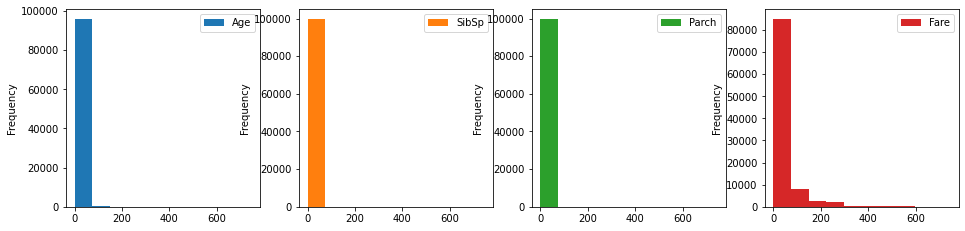

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

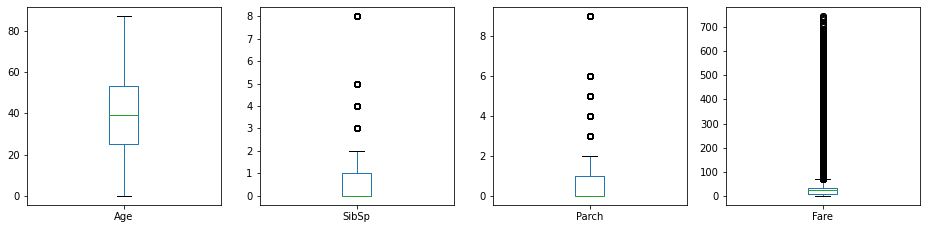

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

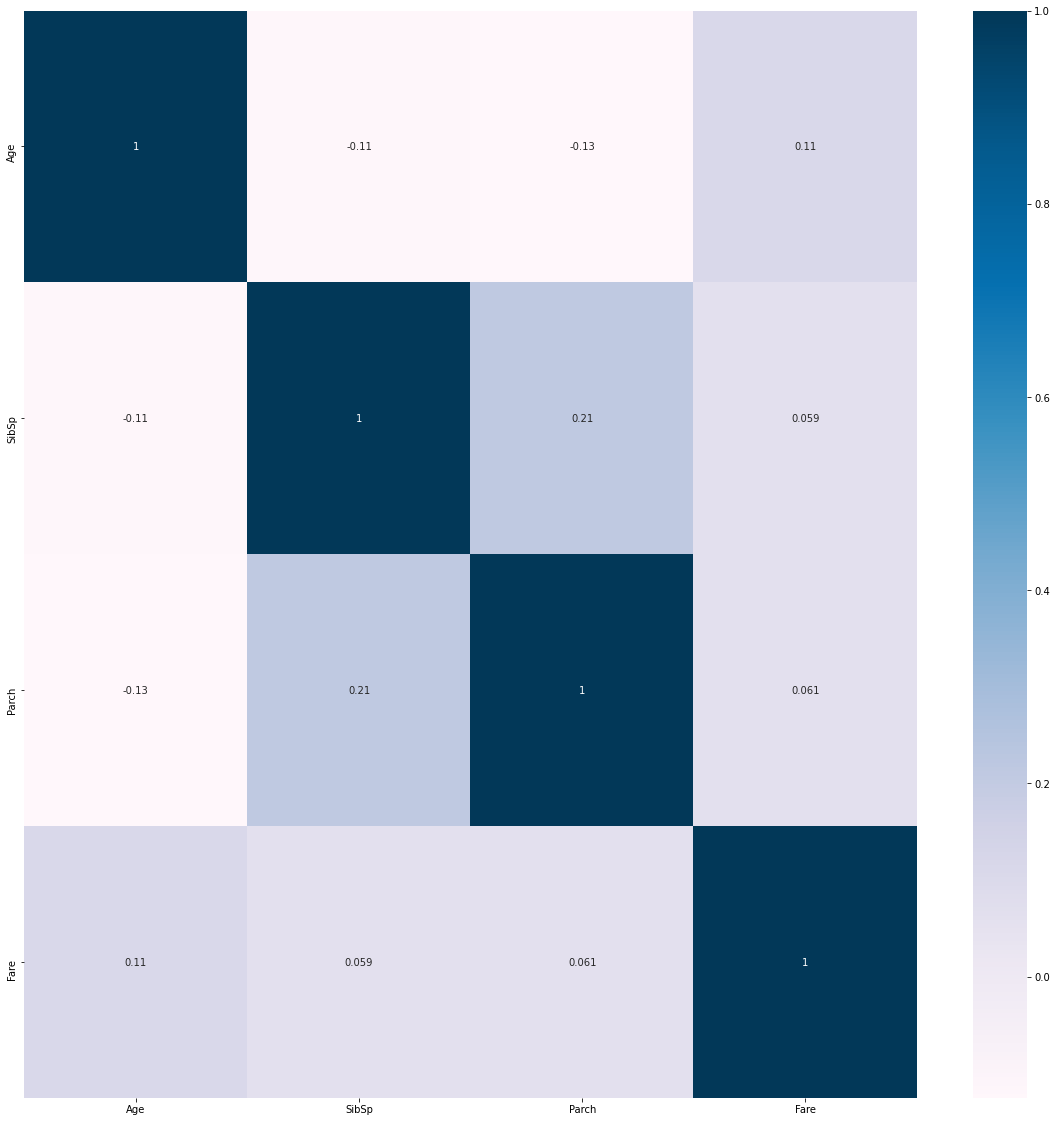

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [29]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 4
Number of categorical columns: 3
Total number of columns in the feature dataframe: 7


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (100000, 7) to array_features_train.shape: (100000, 13)


### 3.c) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (100000, 13) array_target_train.shape: (100000,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
auto_model = StructuredDataClassifier(loss=DEFAULT_LOSS, metrics=DEFAULT_METRICS, max_trials=MAX_TRIALS,
                                      objective=kt.Objective("val_accuracy", direction="max"), seed=RNG_SEED)
auto_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, validation_split=VAL_SET_RATIO, batch_size=BATCH_SIZE, verbose=2)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Trial 45 Complete [00h 02m 38s]
val_accuracy: 0.7702000141143799

Best val_accuracy So Far: 0.7715499997138977
Total elapsed time: 01h 56m 51s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
3125/3125 [==============================] - 14s 4ms/step - loss: 0.4976 - accuracy: 0.7652
Epoch 2/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.4928 - accuracy: 0.7687
Epoch 3/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.4918 - accuracy: 0.7692
Epoch 4/10
3125/3125 [==============================] - 14s 4ms/step - loss: 0.4911 - accuracy: 0.7694
Epoch 5/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.4906 - accuracy: 0.7697
Epoch 6/10
3125/3125 [==============================] - 14s 4ms/step - loss: 0.4901 - accuracy: 0.7703
Epoch 7/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.4898 - accuracy: 0.7708
Epoch 8/10
3125/3125 [==============================] - 13s 4ms/step - loss: 0.4895 - accuracy: 0.

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [39]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [40]:
final_model = auto_model.export_model()
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 13)                0         
_________________________________________________________________
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense (Dense)                (None, 32)                448       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

### 6.b) Load Test Dataset and Prepare the Submission File

In [41]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021apr/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   PassengerId  Pclass              Name  ...   Fare   Cabin  Embarked
0       100000       3  Holliday, Daniel  ...  63.01     NaN         S
1       100001       3  Nguyen, Lorraine  ...   5.81     NaN         S
2       100002       1   Harris, Heather  ...  38.91  B15315         C
3       100003       2      Larsen, Eric  ...  12.93     NaN         S
4       100004       1     Cleary, Sarah  ...  26.89  B22515         C

[5 rows x 11 columns]


In [42]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['PassengerId'] = df_features_test['PassengerId']
print(df_kaggle_submission.head())

   PassengerId
0       100000
1       100001
2       100002
3       100003
4       100004


In [43]:
# Dropping features
df_features_test.drop(columns=['PassengerId','Name','Ticket','Cabin'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   Pclass     Sex   Age  SibSp  Parch   Fare Embarked
0       3    male  19.0      0      0  63.01        S
1       3  female  53.0      0      0   5.81        S
2       1  female  19.0      0      0  38.91        C
3       2    male  25.0      0      0  12.93        S
4       1  female  17.0      0      2  26.89        C


In [44]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (100000, 7) to array_features_test.shape: (100000, 13)


In [45]:
# Make batched predictions
test_predictions = (final_model.predict(array_features_test) > 0.5).astype("int32").ravel()
print(test_predictions)

[0 0 1 ... 0 1 1]


In [46]:
df_kaggle_submission['Survived'] = test_predictions
print(df_kaggle_submission.head())

   PassengerId  Survived
0       100000         0
1       100001         0
2       100002         1
3       100003         0
4       100004         1


In [47]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210608-1650.csv


In [48]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:17:28.019533
